path train: '/kaggle/input/indonesian-food/dataset/train'<br>
path test: '/kaggle/input/indonesian-food/dataset/test'<br>
path valid: '/kaggle/input/indonesian-food/dataset/valid'<br>
ada 4 kelas: bakso gado rendang sate

In [1]:
# import tensorflow as tf
# from tensorflow import keras
# from PIL import Image
# import os
# import numpy as np
# # Let's check size of images
# base_dir = '/kaggle/input/indonesian-food/dataset/train/bakso'
# for image in list(os.walk("/kaggle/input/indonesian-food/dataset/train/bakso"))[0][2]:
#   a = Image.open(os.path.join(base_dir, image))
#   print(np.asarray(a).shape)

In [2]:
import tensorflow as tf

print('\\u2022 Using TensorFlow Version:', tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


\u2022 Using TensorFlow Version: 2.11.0


In [3]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


In [4]:
# import os

# base_dir = '/kaggle/input/indonesian-food/dataset/train'

# bakso_dir = os.path.join(base_dir, 'bakso')
# gado_dir = os.path.join(base_dir, 'gado')
# gudeg_dir = os.path.join(base_dir, 'gudeg')
# rendang_dir = os.path.join(base_dir, 'rendang')
# sate_dir = os.path.join(base_dir, 'sate')

# print('total training bakso images:', len(os.listdir(bakso_dir)))
# print('total training gado images:', len(os.listdir(gado_dir)))
# print('total training gudeg images:', len(os.listdir(gudeg_dir)))
# print('total training rendang images:', len(os.listdir(rendang_dir)))
# print('total training sate images:', len(os.listdir(sate_dir)))

# bakso_files = os.listdir(bakso_dir)
# print(bakso_files[:10])

# gado_files = os.listdir(gado_dir)
# print(gado_files[:10])

# gudeg_files = os.listdir(gudeg_dir)
# print(gudeg_files[:10])

# rendang_files = os.listdir(rendang_dir)
# print(rendang_files[:10])

# sate_files = os.listdir(sate_dir)
# print(sate_files[:10])

In [5]:
import os
import tensorflow as tf
import tensorflow.keras.layers as tflayers
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner import HyperModel, RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

IMAGE_SIZE = 299
BATCH_SIZE = 32

model = Sequential()

# base_model = Xception(
#     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
#     include_top=False,
#     weights='imagenet'
# )
# model.add(base_model)
# model.add(tf.keras.layers.GlobalAveragePooling2D())

# nontransfer learning
model.add(tflayers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(32, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(64, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(128, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
model.add(tflayers.Conv2D(256, (3,3), activation='relu'))
model.add(tflayers.MaxPooling2D(2,2))
# model.add(tflayers.Dropout(0.2))
model.add(tflayers.Flatten())

# Tune the hyperparameters for the Dense layer
model.add(Dense(256, activation='relu'))

model.add(Dense(4, activation='softmax'))

# initial_LR = 0.001
# optimizer = tf.keras.optimizers.Adam(learning_rate=initial_LR)
# new_learning_rate = 0.0005
# optimizer.learning_rate.assign(new_learning_rate)

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [6]:

TRAINING_DIR = "/kaggle/input/indonesian-food/dataset/train"
training_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

VALIDATION_DIR = "/kaggle/input/indonesian-food/dataset/val"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(IMAGE_SIZE, IMAGE_SIZE),
	class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(IMAGE_SIZE, IMAGE_SIZE),
	class_mode='categorical',
    batch_size=BATCH_SIZE
)


Found 7754 images belonging to 4 classes.
Found 349 images belonging to 4 classes.


In [7]:
# # Perform hyperparameter tuning
# tuner.search(train_generator, validation_data=validation_generator, epochs=20)

# Get the best hyperparameters and build the final model
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# model = tuner.hypermodel.build(best_hps)

In [8]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# model = tuner.hypermodel.build(best_hps)
# Train the model
history = model.fit(
    train_generator, 
    epochs=50, 
    verbose=1, 
    validation_data = validation_generator
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
243/243 [==============================] - 201s 791ms/step - loss: 1.0435 - accuracy: 0.5084 - val_loss: 1.2338 - val_accuracy: 0.4814
Epoch 2/50
243/243 [==============================] - 173s 711ms/step - loss: 0.8352 - accuracy: 0.6273 - val_loss: 1.3349 - val_accuracy: 0.4241
Epoch 3/50
243/243 [==============================] - 182s 750ms/step - loss: 0.7984 - accuracy: 0.6539 - val_loss: 1.2808 - val_accuracy: 0.4728
Epoch 4/50
243/243 [==============================] - 172s 706ms/step - loss: 0.7075 - accuracy: 0.7116 - val_loss: 1.0834 - val_accuracy: 0.5673
Epoch 5/50
243/243 [==============================] - 165s 680ms/step - loss: 0.6725 - accuracy: 0.7238 - val_loss: 1.0477 - val_accuracy: 0.5759
Epoch 6/50
243/243 [==============================] - 165s 678ms/step - loss: 0.6085 - accuracy: 0.7547 - val_loss: 1.0900 - val_accuracy: 0.5415
Epoch 7/50
243/243 [==============================] - 165s 678ms/step - loss: 0.5895 - accuracy: 0.7645 - val_loss: 0.9695 -

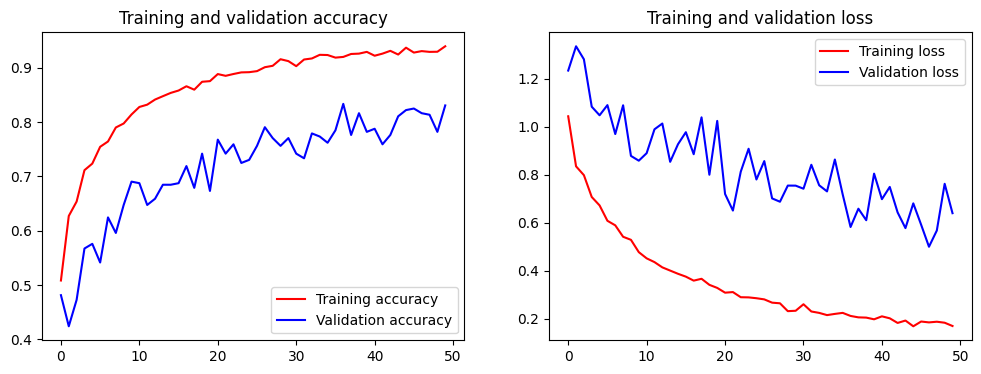

In [9]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].plot(epochs, acc, 'r', label='Training accuracy')
axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axis[0].set_title("Training and validation accuracy")
axis[0].legend(loc=0)

axis[1].plot(epochs, loss, 'r', label='Training loss')
axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
axis[1].set_title("Training and validation loss")
axis[1].legend(loc=0)


plt.show()

In [10]:
# hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
historyFinal = model.fit(
    train_generator, 
    epochs=best_epoch, 
    verbose=1,
    validation_data = validation_generator
)

Epoch 1/37
243/243 [==============================] - 168s 691ms/step - loss: 0.1745 - accuracy: 0.9378 - val_loss: 0.6491 - val_accuracy: 0.8080
Epoch 2/37
243/243 [==============================] - 171s 702ms/step - loss: 0.1668 - accuracy: 0.9405 - val_loss: 0.6051 - val_accuracy: 0.8138
Epoch 3/37
243/243 [==============================] - 170s 700ms/step - loss: 0.1623 - accuracy: 0.9381 - val_loss: 0.8342 - val_accuracy: 0.7736
Epoch 4/37
243/243 [==============================] - 171s 702ms/step - loss: 0.1740 - accuracy: 0.9360 - val_loss: 0.7847 - val_accuracy: 0.8080
Epoch 5/37
243/243 [==============================] - 170s 698ms/step - loss: 0.1692 - accuracy: 0.9400 - val_loss: 0.6112 - val_accuracy: 0.8424
Epoch 6/37
243/243 [==============================] - 165s 679ms/step - loss: 0.1550 - accuracy: 0.9395 - val_loss: 0.7078 - val_accuracy: 0.8109
Epoch 7/37
243/243 [==============================] - 169s 696ms/step - loss: 0.1635 - accuracy: 0.9375 - val_loss: 0.6612 -

In [11]:
# eval_result = hypermodel.evaluate(img_test, label_test)
# print("[test loss, test accuracy]:", eval_result)

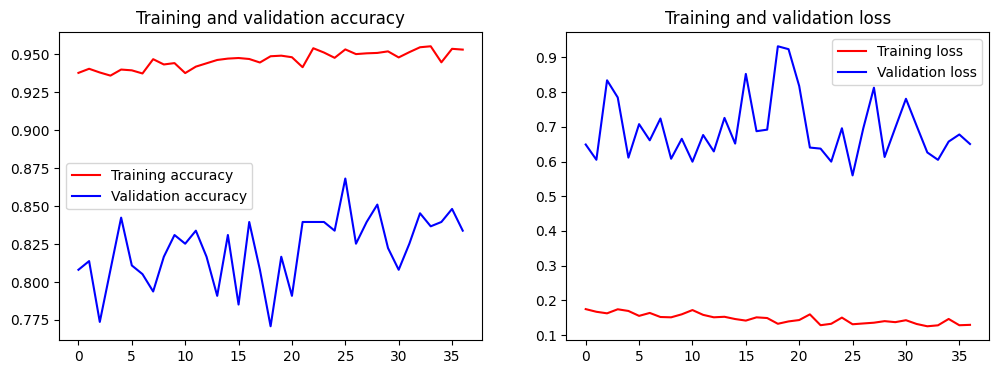

In [12]:
import matplotlib.pyplot as plt

# Plot the results
acc = historyFinal.history['accuracy']
val_acc = historyFinal.history['val_accuracy']
loss = historyFinal.history['loss']
val_loss = historyFinal.history['val_loss']

epochs = range(len(acc))

figure, axis = plt.subplots(1, 2, figsize=(12, 4))

axis[0].plot(epochs, acc, 'r', label='Training accuracy')
axis[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
axis[0].set_title("Training and validation accuracy")
axis[0].legend(loc=0)

axis[1].plot(epochs, loss, 'r', label='Training loss')
axis[1].plot(epochs, val_loss, 'b', label='Validation loss')
axis[1].set_title("Training and validation loss")
axis[1].legend(loc=0)


plt.show()

In [13]:
from datetime import datetime
# current date and time
now = datetime.now()

time_stamp = datetime.timestamp(now)
name = f'model-train-{time_stamp}'
model.save(f'{name}.h5')

In [14]:
# loaded_model = tf.keras.models.load_model('/kaggle/working/model-train-1684748493.064132.h5')

In [15]:
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf



class_names = list(train_generator.class_indices)
print(class_names)
 
# predicting images
TEST_DIR = '/kaggle/input/indonesian-food/dataset/test'
for dirname, _, filenames in os.walk(TEST_DIR):
    if dirname is not TEST_DIR:
        last_dir = os.path.basename(os.path.normpath(dirname))
        correct = 0
        for idx, filename in enumerate(filenames):
            path = filename

            img = load_img(os.path.join(
                os.path.join(TEST_DIR, dirname), filename), target_size=(IMAGE_SIZE, IMAGE_SIZE))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            images = np.vstack([x])
            classes = model.predict(images, batch_size=BATCH_SIZE, verbose=0)
#             classes = loaded_model.predict(images, batch_size=BATCH_SIZE, verbose=0)
            score = tf.nn.softmax(classes[0])
            
            predicted_class = np.argmax(score)
            predicted_class_name = class_names[np.argmax(score)]

            if(last_dir==predicted_class_name): correct += 1
#             print("Image: ", filename)
#             print(
#                 "This image most likely belongs to {} with a {:.2f} percent confidence.\n"
#                 .format(predicted_class_name, 100 * np.max(score))
#             )
        
        print(f'untuk folder {last_dir}')
        print("Jumlah data",len(os.listdir(os.path.join(TEST_DIR, dirname))))
        print("Jumlah data benar", correct)
        print(
            "Akurasi {:.2f}\n"
            .format(100*(correct/len(os.listdir(os.path.join(TEST_DIR, dirname)))))
        )


['bakso', 'gado', 'rendang', 'sate']
untuk folder sate
Jumlah data 214
Jumlah data benar 201
Akurasi 93.93

untuk folder bakso
Jumlah data 214
Jumlah data benar 169
Akurasi 78.97

untuk folder gado
Jumlah data 216
Jumlah data benar 196
Akurasi 90.74

untuk folder rendang
Jumlah data 222
Jumlah data benar 178
Akurasi 80.18

